## Baro Array - Coherence

### Importing

In [1]:
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import obspy
import pandas as pd

from obspy import Stream

from andbro__read_sds import __read_sds

from functions.interpolate_nan import __interpolate_nan

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

### Setting Variables

In [191]:
config = {}

config['klim'] = 50.
config['kstep'] = config['klim'] / 100.

# example 1
config['tbeg'] = obspy.UTCDateTime("2024-03-16 06:00")
config['tend'] = obspy.UTCDateTime("2024-03-16 18:00")

# example 2
# config['tbeg'] = obspy.UTCDateTime("2024-03-23 06:00")
# config['tend'] = obspy.UTCDateTime("2024-03-23 17:00")

config['tbeg'] = obspy.UTCDateTime("2024-03-23 00:00")
config['tend'] = obspy.UTCDateTime("2024-03-25 00:00")

config['seeds'] = [
                   'BW.ROMY.03.LDI',
                   'BW.GELB..LDO',
                   'BW.GRMB..LDO',
                   'BW.ALFT..LDO',
                   'BW.BIB..LDO',
                   'BW.TON..LDO',
]

config['fmin'] = 0.5e-4
config['fmax'] = 0.1

config['path_to_figs'] = data_path+"/romy_baro/figures/"


config['coos'] = { "ALFT":{"lon":11.2795 , "lat":48.142334, "height":593.0},
                   "GELB":{"lon":11.2514 , "lat":48.1629, "height":628.0},
                   "GRMB":{"lon":11.2635 , "lat":48.1406, "height":656.0},
                   "TON":{"lon":11.288809 , "lat":48.173897, "height":564.0},
                   "BIB":{"lon":11.2473 , "lat":48.1522, "height":599.0},
                   "PROMY":{"lon":11.275501 , "lat":48.162941, "height":571.0},
                  }

### Load FURT Data

In [4]:
from andbro__load_FURT_stream import __load_furt_stream

In [5]:
# furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')

### Load Pressure Data

1 Trace(s) in Stream:
BW.PROMY.03.LDI | 2024-03-23T00:00:00.000000Z - 2024-03-25T00:00:00.000000Z | 1.0 Hz, 172801 samples


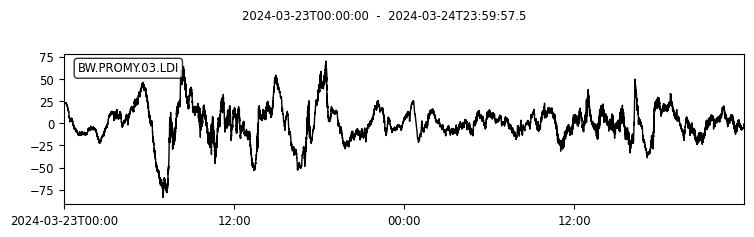

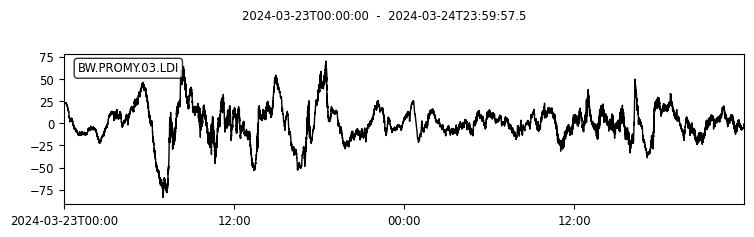

1 Trace(s) in Stream:
BW.GELB..LDO | 2024-03-23T00:00:00.000000Z - 2024-03-25T00:00:00.000000Z | 1.0 Hz, 172801 samples
-> NaN found


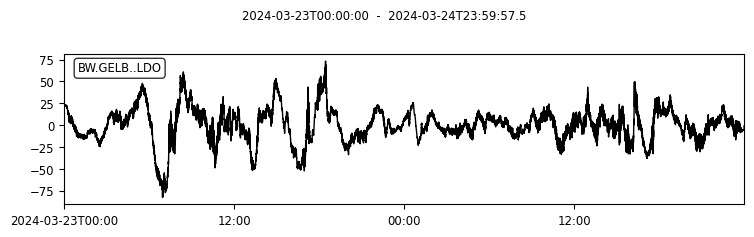

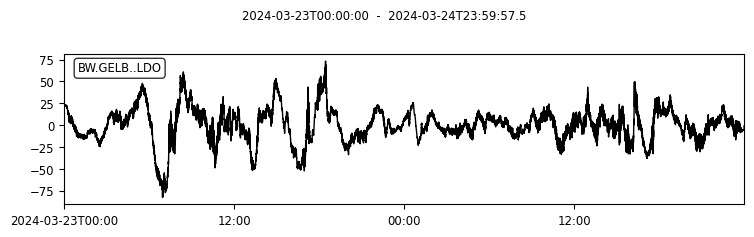

1 Trace(s) in Stream:
BW.GRMB..LDO | 2024-03-23T00:00:00.000000Z - 2024-03-25T00:00:00.000000Z | 1.0 Hz, 172801 samples


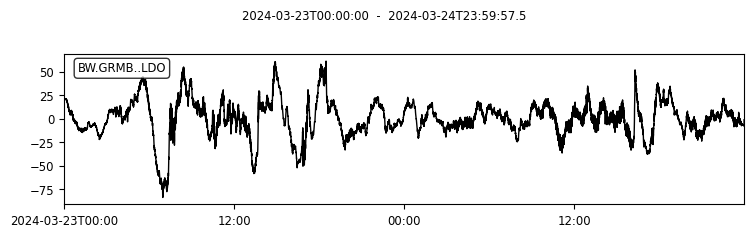

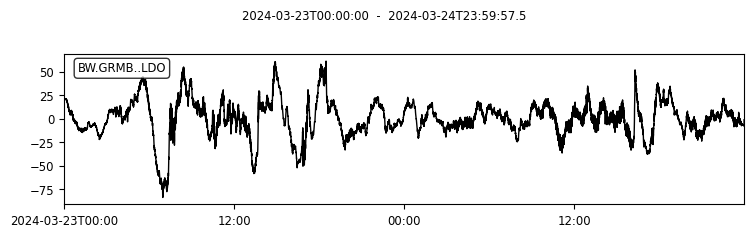

1 Trace(s) in Stream:
BW.ALFT..LDO | 2024-03-23T00:00:00.000000Z - 2024-03-25T00:00:00.000000Z | 1.0 Hz, 172801 samples


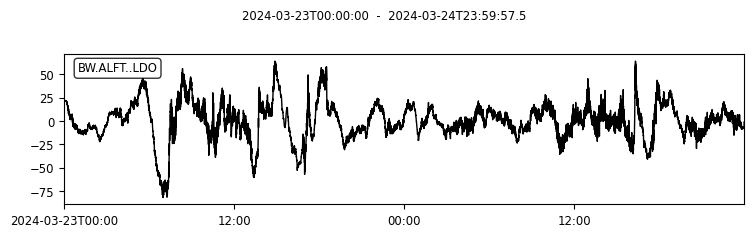

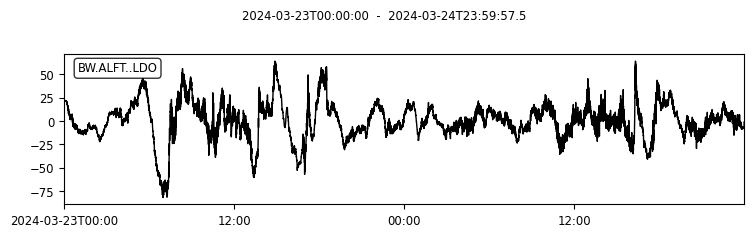

1 Trace(s) in Stream:
BW.BIB..LDO | 2024-03-23T00:00:00.000000Z - 2024-03-25T00:00:00.000000Z | 1.0 Hz, 172801 samples
-> NaN found


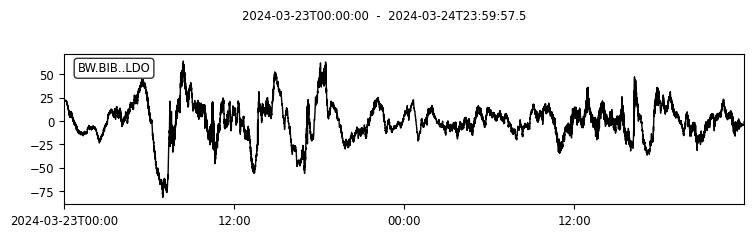

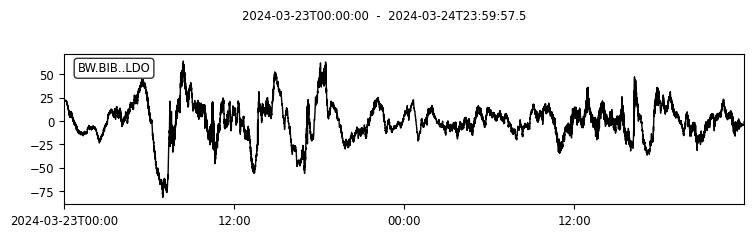

1 Trace(s) in Stream:
BW.TON..LDO | 2024-03-23T00:00:00.000000Z - 2024-03-25T00:00:00.000000Z | 1.0 Hz, 172801 samples
-> NaN found


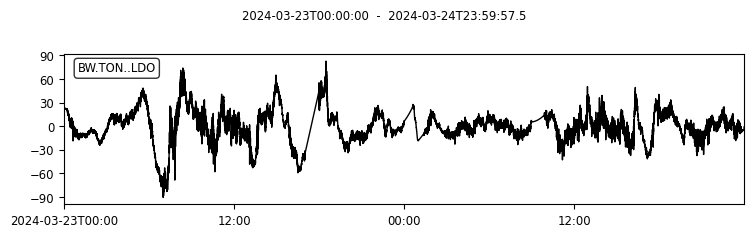

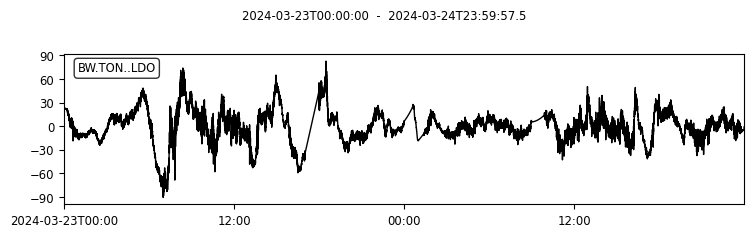

In [6]:
df_pressure = pd.DataFrame()

st = Stream()

for _i, seed in enumerate(config['seeds']):

    if "ROMY" in seed:
        seed = "BW.PROMY.03.LDI"

    ps = __read_sds(archive_path+"temp_archive/", seed, config['tbeg'], config['tend'])
    print(ps)

    for tr in ps:
        if np.isnan(tr.data).any():
            print("-> NaN found")
            tr.data = __interpolate_nan(tr.data)

    try:
        # convert from Pa to hPa
        if "ROMY" in seed:
            ps[0].data = ps[0].data / 100

        ps = ps.detrend("simple")

        ps = ps.taper(0.01, type="cosine")

        ps = ps.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

        ps = ps.resample(config['fmax']*4)

        # convert from hPa to Pa
        ps[0].data = ps[0].data * 100

        if _i == 0:
            df_pressure["time"] = ps[0].times(reftime=config['tbeg'])

        df_pressure[f"{seed.split('.')[0]}.{seed.split('.')[1]}"] = ps[0].data

        ps.plot();

        st += ps

    except:
        print(f"Error: {seed}")


In [9]:
def __compute_baro_gradient_romy(tbeg, tend, status=False, excluded_stations=[], verbose=False):

    ######################
    """
    rotation_X = -u_nz
    rotation_Y =  u_ez
    rotation_Z = 0.5*(u_ne-u_en)
    """
    ######################

    import os
    import numpy as np
    import timeit
    import matplotlib.pyplot as plt
    import matplotlib.colors

    from obspy import UTCDateTime, Stream, read_inventory
    from obspy.clients import fdsn
    from obspy.geodetics.base import gps2dist_azimuth
    from obspy.geodetics import locations2degrees
    from obspy.clients.fdsn import Client, RoutingClient
    from obspy.signal import array_analysis as AA
    from obspy.signal.util import util_geo_km
    from obspy.signal.rotate import rotate2zne
    from datetime import datetime

    import warnings
    warnings.filterwarnings('ignore')

    if os.uname().nodename == 'lighthouse':
        root_path = '/home/andbro/'
        data_path = '/home/andbro/kilauea-data/'
        archive_path = '/home/andbro/freenas/'
        bay_path = '/home/andbro/ontap-ffb-bay200/'
        lamont_path = '/home/andbro/lamont/'
    elif os.uname().nodename == 'kilauea':
        root_path = '/home/brotzer/'
        data_path = '/import/kilauea-data/'
        archive_path = '/import/freenas-ffb-01-data/'
        bay_path = '/import/ontap-ffb-bay200/'
        lamont_path = '/lamont/'
    elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
        root_path = '/home/brotzer/'
        data_path = '/import/kilauea-data/'
        archive_path = '/import/freenas-ffb-01-data/'
        bay_path = '/import/ontap-ffb-bay200/'
        lamont_path = '/lamont/'

    # _____________________________________________________

    # start timer for runtime
    start_timer = timeit.default_timer()

    # _____________________________________________________

    # generate configuration object
    config = {}

    # convert to utcdatetime object
    config['tbeg'] = UTCDateTime(tbeg)
    config['tend'] = UTCDateTime(tend)

    # select the fdsn client for the stations
    # config['fdsn_client'] = {"BW":Client('http://jane'), "GR":Client('BGR')}
    config['fdsn_client'] = {"BW":Client('LMU'), "GR":Client('BGR')}

    # define output seed
    config['out_seed'] = "BW.BRMY"

    config['location'] = "00"

    # specify frequency range
    config['freq2'] = 0.01
    config['freq1'] = 0.0001
    config['apply_bandpass'] = True

    # decide if information is printed while running the code
    config['verbose'] = verbose

    # BRMY array information
    config['array_stations'] = [
                               'BW.PROMY.03.LDI',
                               'BW.GELB..LDO',
                               'BW.GRMB..LDO',
                               'BW.ALFT..LDO',
                               'BW.BIB..LDO',
                               'BW.TON..LDO',
                                ]

    # specify reference station
    config['reference_station'] = 'BW.PROMY.03.LDI'

    # exclude stations
    config['subarray_stations'] = [_sta for _sta in config['array_stations'] if _sta not in excluded_stations]

    # create subarray mask
    config['subarray_mask'] = range(len(config['subarray_stations']))

    # set coordinates
    config['coo'] = {  "ALFT":{"lon":11.2795 , "lat":48.142334, "height":593.0},
                       "GELB":{"lon":11.2514 , "lat":48.1629, "height":628.0},
                       "GRMB":{"lon":11.2635 , "lat":48.1406, "height":656.0},
                       "TON":{"lon":11.288809 , "lat":48.173897, "height":564.0},
                       "BIB":{"lon":11.2473 , "lat":48.1522, "height":599.0},
                       "PROMY":{"lon":11.275501 , "lat":48.162941, "height":571.0},
                      }

    # adr parameters
    config['vp'] = 1 # 5000 #6264. #1700
    config['vs'] = 1 # 3500 #3751. #1000
    config['sigmau'] = 1e-7 # 0.0001

    # _____________________________________________________

    def __get_inventory_and_distances(config):

        coo = []
        for i, station in enumerate(config['subarray_stations']):

            net, sta, _, _ = station.split(".")

            loc, cha = "", "*HZ"

            # change PROMY
            if sta == "PROMY":
                sta, cha = "ROMY", "*JN"

            try:
                inven = config['fdsn_client'][net].get_stations(
                                                                network=net,
                                                                station=sta,
                                                                channel=cha,
                                                                location=loc,
                                                                starttime=config['tbeg'],
                                                                endtime=config['tend'],
                                                                level='response'
                                                                )
            except:
                return [], []
                print("fail")

            # get coordinates
            l_lon =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['longitude'])
            l_lat =  float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['latitude'])
            height = float(inven.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['elevation'])

            print(l_lon, l_lat, height)

            if station == config['reference_station']:
                o_lon, o_lat, o_height = l_lon, l_lat, height

            lon, lat = util_geo_km(o_lon, o_lat, l_lon, l_lat)

            # convert unit from km to m
            coo.append([lon*1000, lat*1000, height-o_height])

        return inven, np.array(coo)

    def __check_samples_in_stream(st, config):

        Rnet, Rsta, _, _ = config['reference_station'].split(".")

        Rsamples = st.select(network=Rnet, station=Rsta)[0].stats.npts

        for tr in st:
            if tr.stats.npts != Rsamples:
                print(f" -> removing {tr.stats.station} due to improper number of samples ({tr.stats.npts} not {Rsamples})")
                st.remove(tr)

        return st

    def __get_data(config):

        config['subarray'] = []

        st = Stream()

        for k, station in enumerate(config['subarray_stations']):

            net, sta, loc, cha = station.split(".")

            print(f" -> requesting {net}.{sta}.{loc}.{cha}") if config['verbose'] else None

            # try to get waveform data
            try:
                st00 = __read_sds(archive_path+"temp_archive/", station, config['tbeg'], config['tend'])
                # print(data)

            except Exception as E:
                print(E) if config['verbose'] else None
                print(f" -> getting waveforms failed for {net}.{sta}.{loc}.{cha} ...")
                continue

            # merge if masked
            if len(st00) > 1:
                print(f" -> merging stream. Length: {len(st00)} -> 1") if config['verbose'] else None
                st00 = st00.merge(method=1, fill_value="interpolate")

            # interpolate nan values
            for tr in st00:
                if np.isnan(tr.data).any():
                    print(" -> NaN found")
                    tr.data = __interpolate_nan(tr.data)

            # successfully obtained
            if len(st00) == 3:
                print(f" -> obtained: {net}.{sta}")

            # correect scaling for PROMY.03
            if sta == "PROMY" and loc == "03":
                for tr in st00:
                    tr.data /= 100

            # resampling using decitmate
            st00 = st00.detrend("linear");

            # assign reference station stream
            if station == config['reference_station']:
                # ref_station = stats.copy().resample(40, no_filter=False)
                ref_station = st00.copy()

            st += st00

            # create station list for obtained stations
            config['subarray'].append(f"{st00[0].stats.network}.{st00[0].stats.station}")

        if verbose:
            st.plot(equal_scale=False);

        # update subarray stations
        config['subarray_stations'] = config['subarray']

        print(f" -> obtained: {len(st)} of {len(config['subarray_stations'])} stations!") if config['verbose'] else None

        if len(st) == 0:
            return st, Stream(), config
        else:
            return st, ref_station, config

    def __compute_ADR(st, config, ref_station):

        # prepare data arrays
        tsz, tsn, tse = [], [], []
        for tr in st:
            try:
                if "Z" in tr.stats.channel:
                    tsz.append(tr.data)
                elif "N" in tr.stats.channel:
                    tsn.append(tr.data)
                elif "E" in tr.stats.channel:
                    tse.append(tr.data)
            except:
                print(" -> stream data could not be appended!")

        # make sure input is array type
        tse, tsn, tsz = np.array(tse), np.array(tsn), np.array(tsz)

        # define array for subarray stations with linear numbering
        substations = np.arange(len(config['subarray_stations']))

        try:
            result = AA.array_rotation_strain(substations,
                                              np.transpose(tse),
                                              np.transpose(tsn),
                                              np.transpose(tsz),
                                              config['vp'],
                                              config['vs'],
                                              config['dist'],
                                              config['sigmau'],
                                             )
        except Exception as E:
            print(E)
            print("\n -> failed to compute ADR...")
            return None

        # create rotation stream and add data
        out = Stream()
        out += ref_station.copy()
        out += ref_station.copy()
        out += ref_station.copy()

        out[0].data = result['ts_w3']
        out[1].data = result['ts_w2']
        out[2].data = result['ts_w1']

        out[0].stats.channel = 'BDZ'
        out[1].stats.channel = 'BDN'
        out[2].stats.channel = 'BDE'

        out[0].stats.station = config['out_seed'].split(".")[1]
        out[1].stats.station = config['out_seed'].split(".")[1]
        out[2].stats.station = config['out_seed'].split(".")[1]

        out[0].stats.network = config['out_seed'].split(".")[0]
        out[1].stats.network = config['out_seed'].split(".")[0]
        out[2].stats.network = config['out_seed'].split(".")[0]

        out[0].stats.location = config['location']
        out[1].stats.location = config['location']
        out[2].stats.location = config['location']

        out = out.detrend('linear')

        return out

    def __adjust_time_line(st0, reference="BW.ROMY"):

        Rnet, Rsta, _, _ = reference.split(".")

        ref_start = st0.select(network=Rnet, station=Rsta)[0].stats.starttime
        ref_times = st0.select(network=Rnet, station=Rsta)[0].times()

        dt = st0.select(network=Rnet, station=Rsta)[0].stats.delta

        for tr in st0:
            times = tr.times(reftime=ref_start)

            tr.data = np.interp(ref_times, times, tr.data)
            tr.stats.starttime = ref_start

        return st0

    # __________________________________________________________
    # MAIN

    # launch a times
    start_timer1 = timeit.default_timer()

    # status of stations loaded
    config['stations_loaded'] = np.ones(len(config['subarray_stations']))

    # request data for pfo array
    st, ref_station, config = __get_data(config)

    # get inventory and coordinates/distances
    # inv, config['coo'] = __get_inventory_and_distances(config)

    for tr in st:
        tr.stats.channel = "LDZ"

    # add placebo N component
    _stN = st.copy()
    for tr in _stN:
        tr.stats.channel = "LDN"

    # add placebo E component
    _stE = st.copy()
    for tr in _stE:
        tr.stats.channel = "LDE"

    st += _stN.copy()
    st += _stE.copy()

    # processing
    st = st.detrend("linear")
    st = st.detrend("demean")

    # bandpass filter
    if config['apply_bandpass']:
        st = st.taper(0.02, type="cosine")
        st = st.filter('bandpass', freqmin=config['freq1'], freqmax=config['freq2'], corners=4, zerophase=True)
        print(f" -> bandpass: {config['freq1']} - {config['freq2']} Hz")

    # compute relataive distances
    dist = []
    for k in config['coo'].keys():

        coo = config['coo'][k]

        ref_sta = config['reference_station'].split(".")[1]

        # reference
        ref = config['coo'][ref_sta]
        ref_lon, ref_lat, ref_height = ref['lon'], ref['lat'], ref['height']

        # convert
        lon, lat = util_geo_km(ref_lon, ref_lat, coo['lon'], coo['lat'])

        # convert unit from km to m
        dist.append([lon*1000, lat*1000, coo['height']-ref_height])

    config['dist'] = np.array(dist)


    # plot station coordinates for check up
    if verbose:
        import matplotlib.pyplot as plt
        for station in config['subarray_stations']:
            print(station)
            _net, _sta = station.split(".")
            plt.scatter(config['coo'][_sta]['lon'], config['coo'][_sta]['lat'], label=_sta)
            plt.legend()
        plt.show();

    # check if enough stations for ADR are available otherwise continue
    if len(st) < 3*3:
        print(" -> not enough stations (< 3) for ADR computation!")
        return
    else:
        print(f" -> continue computing ADR for {int(len(st)/3)} of {len(config['subarray_mask'])} stations ...")

    # homogenize the time line
    # st = __adjust_time_line(st, reference=config['reference_station'])

    # trim to requested interval
    # st = st.trim(config['tbeg'], config['tend'])

    # check for same amount of samples
    __check_samples_in_stream(st, config)

    # compute array derived rotation (ADR)
    try:
        rot = __compute_ADR(st, config, ref_station)
    except Exception as e:
        print(e)
        # return None

    # get mean starttime
    # tstart = [tr.stats.starttime - tbeg for tr in st]
    # for tr in st:
    #     tr.stats.starttime = tbeg + np.mean(tstart)

    # trim to requested interval
    rot = rot.trim(config['tbeg'], config['tend'])

    # remove Z trace (not possible to compute for pressure)
    for tr in rot:
        if "Z" in tr.stats.channel:
            rot.remove(tr);

    # stop times
    stop_timer1 = timeit.default_timer()
    print(f"\n -> Runtime: {round((stop_timer1 - start_timer1)/60, 2)} minutes\n")

    return rot

 -> requesting BW.PROMY.03.LDI
 -> requesting BW.GELB..LDO
 -> NaN found
 -> requesting BW.GRMB..LDO
 -> requesting BW.ALFT..LDO
 -> requesting BW.BIB..LDO
 -> NaN found
 -> requesting BW.TON..LDO
 -> NaN found


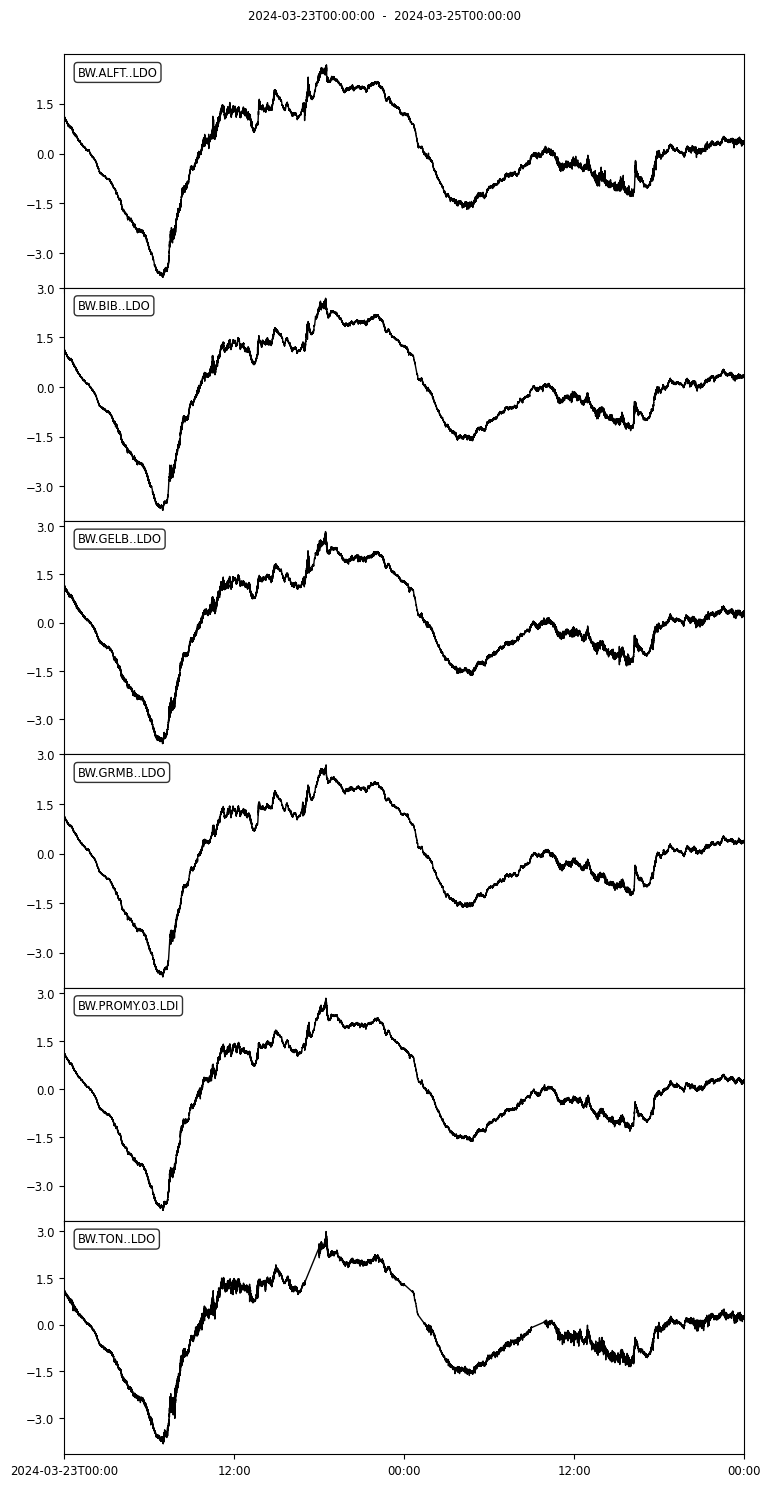

 -> obtained: 6 of 6 stations!
 -> bandpass: 0.0001 - 0.01 Hz
BW.PROMY
BW.GELB
BW.GRMB
BW.ALFT
BW.BIB
BW.TON


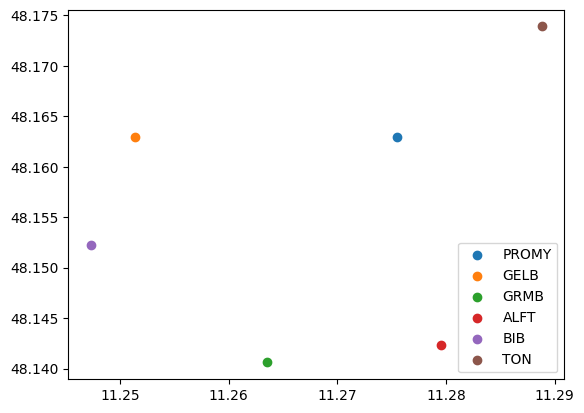

 -> continue computing ADR for 6 of 6 stations ...

 -> Runtime: 0.61 minutes



In [11]:
bgrad0 = __compute_baro_gradient_romy(config['tbeg'],
                                     config['tend'],
                                     status=False,
                                     excluded_stations=[],
                                     verbose=True
                                    )

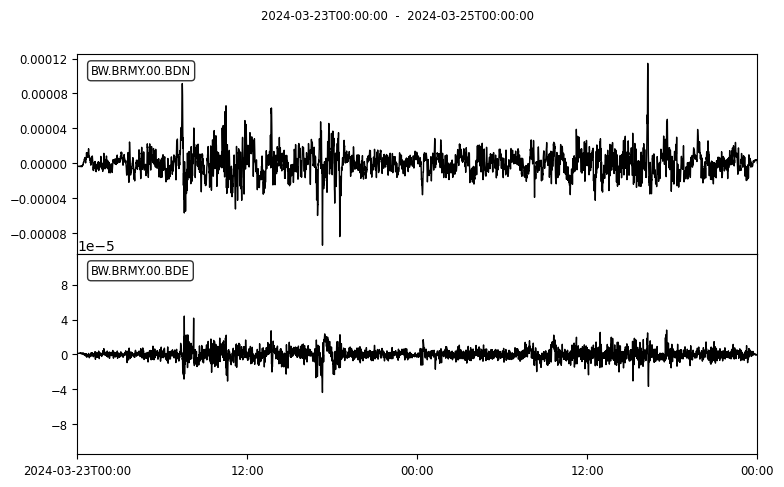

In [14]:
bgrad0.plot();

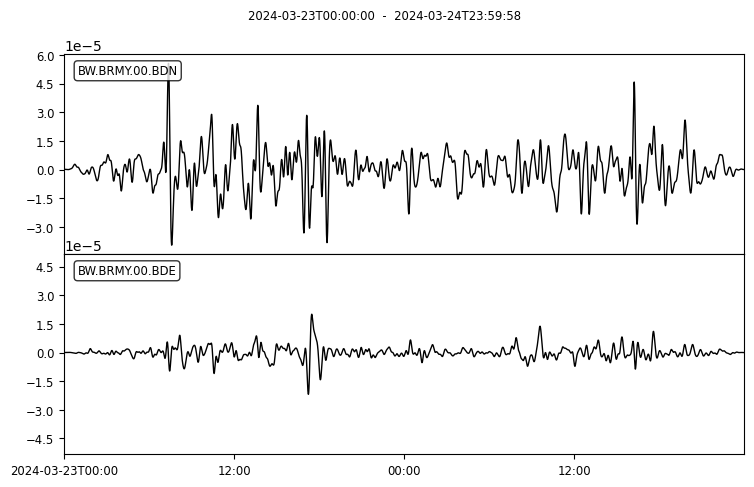

In [179]:
fmin, fmax = 0.00005, 0.001

bgrad = bgrad0.copy()

bgrad = bgrad.detrend("demean")
bgrad = bgrad.detrend("linear")

bgrad = bgrad.taper(0.05)

bgrad = bgrad.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);

bgrad = bgrad.resample(0.5, no_filter=True)

bgrad.plot();

In [180]:
from functions.get_angle import __get_angle

In [181]:
N = bgrad.select(channel="*N")[0].data
E = bgrad.select(channel="*E")[0].data

t = bgrad.select(channel="*N")[0].times()

# absolute gradient
bgrad_abs = np.sqrt(N**2 + E**2)

# angle of gradient (east = 0, postive anti-clockwise)
bgrad_ang = __get_angle(N, E, out="deg")

# bgrad_ang = ((bgrad_ang + 90) % 360)

# angle relative to north
bgrad_ang = ((bgrad_ang + 90) % 360) - 180

In [182]:
df_pressure

time   BW.PROMY    BW.GELB    BW.GRMB    BW.ALFT     BW.BIB  \
0           0.0  14.000629  13.896756  12.676256  13.323215  13.531741   
1           2.5  21.871786  21.710328  19.806583  20.816997  21.138066   
2           5.0  20.159366  20.010725  18.256115  19.186482  19.483766   
3           7.5  21.194017  21.038258  19.195132  20.172700  20.483414   
4          10.0  20.499291  20.348704  18.565702  19.510201  19.812906   
...         ...        ...        ...        ...        ...        ...   
69115  172787.5  -5.827937  -6.177246  -7.466930  -7.986097  -4.578106   
69116  172790.0  -5.865601  -6.251436  -7.713571  -8.257474  -4.518296   
69117  172792.5  -5.918429  -6.263394  -7.540310  -8.060776  -4.679137   
69118  172795.0  -2.423219  -2.607359  -3.329569  -3.569879  -1.801312   
69119  172797.5  -1.034049  -1.061528  -1.133978  -1.204077  -0.905372   

          BW.TON  
0      13.630568  
1      21.293594  
2      19.626715  
3      20.634105  
4      19.958052  
...          ...  
69115  -5.490878  
69116  -5.510367  
69117  -5.580571  
69118  -2.264862  
69119  -0.990309  

[69120 rows x 7 columns]

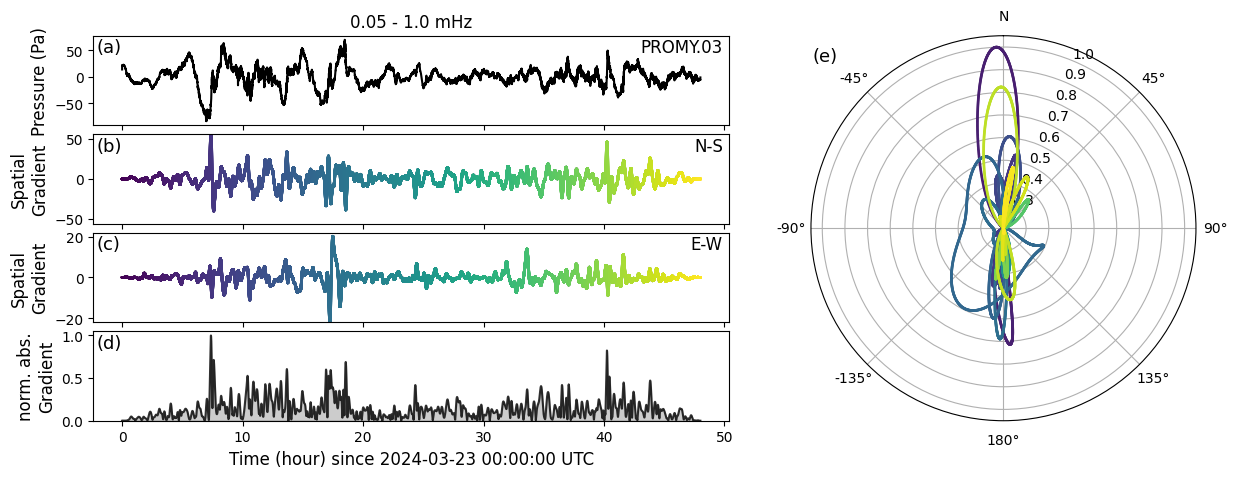

In [192]:
def __makeplot():
    
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec


    # normalized absolute gradient
    r = bgrad_abs / max(bgrad_abs)

    # specify limit for r
    rlim = 0.2

    # angle as radians
    theta = np.deg2rad(bgrad_ang)
    
    # ___________________________________________
    
    tscale, tunit = 1/3600, "hour"
    
    gscale, gunit = 1e6, ""

    Ncol, Nrow = 9, 4

    font = 12

    lw = 1

    fig = plt.figure(figsize=(15, 5))
    
    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.1, wspace=0.2)
    # gs2 = GridSpec(Nrow, Ncol, figure=fig, hspace=1)

    ax0 = fig.add_subplot(gs1[0, :5])
    ax1 = fig.add_subplot(gs1[1, :5])
    ax2 = fig.add_subplot(gs1[2, :5])
    ax3 = fig.add_subplot(gs1[3, :5])
    ax4 = fig.add_subplot(gs1[0:4, 5:], polar=True)

    axes = [ax0, ax1, ax2, ax3, ax4]


    # ___________________________________________
    
    tt = np.array(df_pressure.time)
    pp = np.array(df_pressure['BW.PROMY'])
    
    ax0.plot(tt*tscale, pp, color="k", label="PROMY.03")
    ax0.set_xticklabels([])
    ax0.set_ylabel(f"Pressure (Pa)", fontsize=font)
    # ax0.legend(loc=1)
    ax0.text(0.99, 0.97, "PROMY.03", ha="right", va="top", transform=ax0.transAxes, fontsize=font)

    # ___________________________________________
    
    # ax1.plot(t*tscale, N*gscale, color=t*tscale)
    ax1.scatter(t*tscale, N*gscale, c=t*tscale, s=1, label="N-S")
    ax1.set_xticklabels([])
    ax1.set_ylim(-max(abs(N))*gscale, max(abs(N))*gscale)
    ax1.set_ylabel(f"Spatial\nGradient", fontsize=font)
    # ax1.legend(loc=1, handlelength=0, handletextpad=1)
    ax1.text(0.99, 0.97, "N-S", ha="right", va="top", transform=ax1.transAxes, fontsize=font)

    # ___________________________________________
    
    # ax2.plot(t*tscale, E*gscale)
    ax2.scatter(t*tscale, E*gscale, c=t*tscale, s=1, label="E-W")
    ax2.set_xticklabels([])
    ax2.set_ylim(-max(abs(E))*gscale, max(abs(E))*gscale)
    ax2.set_ylabel(f"Spatial\nGradient", fontsize=font)
    # ax2.legend(loc=1, handlelength=-1, handletextpad=0)
    ax2.text(0.99, 0.97, "E-W", ha="right", va="top", transform=ax2.transAxes, fontsize=font)

    # ___________________________________________
    
    ax3.plot(t*tscale, r, color='k', alpha=0.8)
    ax3.fill_between(t*tscale, r, color='k', alpha=0.2)
    ax3.set_ylim(0, 1.05)
    ax3.set_ylabel(f"norm. abs.\nGradient", fontsize=font)

    # ___________________________________________
    
    ax4.scatter(theta[r>rlim], r[r>rlim], c=t[r>rlim], s=1, zorder=2)
    ax4.set_theta_zero_location("N")
    ax4.set_rmin(0.2)
    ax4.set_rmax(1.05)
    ax4.set_rlabel_position(-22.5)  
    ax4.grid(True) 
    
    ax4.set_xticklabels(["N", "-45°", "-90°", "-135°", "180°", "135°", "90°", "45°"])

    ax3.set_xlabel(f"Time ({tunit}) since {config['tbeg'].date} {str(config['tbeg'].time)[:10]} UTC", fontsize=font)
    
    ax0.set_title(f"{fmin*1e3} - {fmax*1e3} mHz", fontsize=font)
    
    for _k, (ll, ax) in enumerate(zip(['(a)','(b)','(c)','(d)', '(e)'], axes)):
        ax.text(0.005, 0.97, ll, ha="left", va="top", transform=ax.transAxes, fontsize=font+1)

    plt.show();
    return fig
    
fig = __makeplot()

fig.savefig(config['path_to_figs']+f"RB_{config['tbeg'].date}_gradient.png", format="png", dpi=150, bbox_inches='tight')
